# Binance 옵션 포지션 합성

In [1]:
import ipywidgets as widgets
import requests
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

MINIMUM_IV = 0.01

### 블랙-숄즈 모형 (Black–Scholes model)

\begin{align}
& c = S_{0} N(d_{1}) - Ke^{-rT} N(d_{2}) \\
& p = Ke^{-rT} N(-d_{2}) - S_{0} N(-d_{1}) \\
\\
& d_{1}= {\ln({S_{0} / K}) + (r + {\sigma^2 / 2})T \over \sigma \sqrt{T}} \\
& d_{2}= {\ln({S_{0} / K}) + (r - {\sigma^2 / 2})T \over \sigma \sqrt{T}} = d_{1} - \sigma \sqrt{T}
\end{align}


### 누적정규분포함수 (Cumulative normal distribution function)

\begin{equation}
N(x) = 
\begin{cases}
1 - N^\prime(x)(a_{1}k + a_{2}k^2 + a_{3}k^3 + a_{4}k^4 + a_{5}k^5) & \mbox{if } \geq 0 \\
1 - N(-x) & \mbox{if } < 0
\end{cases} \\
\end{equation}

단,

\begin{matrix}
k = {1 \over 1 + \gamma x}, & \gamma = 0.2316419 \\
a_{1} = 0.31938153, & a_{2} = -0.356563782 \\
a_{3} = 1.781477937, & a_{4} = -1.821255978 \\
a_{5} = 1.330274429 & N^\prime(x) = {1 \over \sqrt{2 \pi}} e^{-x^{2} / 2}
\end{matrix}

In [2]:
def get_d1(s, k, t, r, v):
    return (np.log(s / k) + (r + v * v * 0.5) * t) / (v * np.sqrt(t))


def get_d2(s, k, t, r, v):
    return (np.log(s / k) + (r - v * v * 0.5) * t) / (v * np.sqrt(t))


def get_d1_with_d2(s, k, t, r, v):
    d1 = get_d1(s, k, t, r, v)
    d2 = d1 - (v * np.sqrt(t))
    return (d1, d2)


def get_nm_cdf(x):
    a1 = 0.31938153
    a2 = -0.356563782
    a3 = 1.781477937
    a4 = -1.821255978
    a5 = 1.330274429

    abs_x = np.abs(x)
    k = 1.0 / (1.0 + 0.2316419 * abs_x)
    n_x = 1.0 - (np.exp(-1*abs_x*abs_x*0.5) / np.sqrt(2*np.pi)) * (a1*k + a2*k*k + a3*k*k*k + a4*k*k*k*k + a5*k*k*k*k*k)

    return np.where(0 > x, 1.0 - n_x, n_x)


def get_opt_prc(side, s, k, t, r, v):
    d1, d2 = get_d1_with_d2(s, k, t, r, v)

    if 'CALL' == side:
        opt_prc = s * get_nm_cdf(d1) - k * np.exp(-1 * r * t) * get_nm_cdf(d2)
    else:
        opt_prc = k * np.exp(-1 * r * t) * get_nm_cdf(-1 * d2) - s * get_nm_cdf(-1 * d1)

    return opt_prc

In [3]:
side = 'CALL'
strike_prc = 1500
cur_underlying_prc = 1500
volatility = 0.3
remain_year = 10 / 365
interest_rate = 0.05

d1, d2 = get_d1_with_d2(cur_underlying_prc, strike_prc, remain_year, interest_rate, volatility)
opt_prc = get_opt_prc(side, cur_underlying_prc, strike_prc, remain_year, remain_year, volatility)

print('opt_prc:', opt_prc)

opt_prc: 30.267095553193144


### Delta

\begin{align}
& \Delta_{call} = N(d_{1}) \\
& \Delta_{put} = N(d_{1}) - 1
\end{align}


### Gamma

\begin{equation}
\Gamma = {N^\prime (d_{1}) \over S_{0} \sigma \sqrt{T}} \\
N^\prime(x) = {1 \over \sqrt {2 \pi} } e^{-x^2 / 2}
\end{equation}


### Theta

\begin{align}
& \Theta_{call} = - {S_{0} N^\prime (d_{1}) \sigma \over 2 \sqrt{T}} - r K e^{-rT} N(d_{2}) \\
& \Theta_{put} = - {S_{0} N^\prime (d_{1}) \sigma \over 2 \sqrt{T}} + r K e^{-rT} N(-d_{2})
\end{align}


### Vega

\begin{equation}
\mathcal{V} = S_{0} \sqrt {T} N^\prime(d_{1})
\end{equation}


### Rho

\begin{align}
& \rho_{call} = K T e^{-rT} N(d_{2}) \\
& \rho_{put} = -K T e^{-rT} N(-d_{2})
\end{align}

In [4]:
def get_delta(side, d1):
    if 'CALL' == side:
        return get_nm_cdf(d1)
    else:
        return get_nm_cdf(d1) - 1

def get_gamma(s, t, v, d1):
    return n_prime(d1) / (s * v * np.sqrt(t))

def get_theta(side, s, k, t, r, v, d1, d2):
    tmp = (-1 * s * n_prime(d1) * v) / (2 * np.sqrt(t))

    if 'CALL' == side:
        return (tmp - (r * k * np.exp(-1 * r * t) * get_nm_cdf(d2)))
    else:
        return (tmp + (r * k * np.exp(-1 * r * t) * get_nm_cdf(-1 * d2)))

def get_vega(s, t, d1):
    return s * np.sqrt(t) * n_prime(d1)

def get_rho(side, k, t, r, d2):
    if 'CALL' == side:
        return k * t * np.exp(-1 * t) * get_nm_cdf(d2)
    else:
        return -1 * k * t * np.exp(-1 * t) * get_nm_cdf(-1 * d2)

def n_prime(x):
    return np.exp((-1 * (x*x)) / 2) / np.sqrt(2 * np.pi)

In [5]:
side = 'CALL'
strike_prc = 1500
cur_underlying_prc = 1500
volatility = 0.3
opt_prc = 20
remain_year = 0.022
interest_rate = 0.05

d1, d2 = get_d1_with_d2(cur_underlying_prc, strike_prc, remain_year, interest_rate, volatility)
print('delta:', get_delta(side, d1))
print('gamma:', get_gamma(cur_underlying_prc, remain_year, volatility, d1))
print('theta:', get_theta(side, cur_underlying_prc, strike_prc, remain_year, interest_rate, volatility, d1, d2) / 365)
print('vega:', get_vega(cur_underlying_prc, remain_year, d1) * 0.01)
print('rho:', get_rho(side, strike_prc, remain_year, interest_rate, d2) * 0.01)

delta: 0.5187312020030233
gamma: 0.005970451306461272
theta: -1.7590160340940564
vega: 0.8866120190094988
rho: 0.16172800876835974


### Newton-Raphson Method로 내재 변동성 (Implied Volatility, IV) 계산

\begin{equation}
\sigma_{n+1} = \sigma_{n} - {f(\sigma_{n}) \over f^\prime(\sigma_{n})}
\end{equation}

In [6]:
def get_iv(side, opt_prc, s, k, t, r):
    intrinsic_value = 0.0

    if 'CALL' == side:
        intrinsic_value = s - (k * np.exp(-1 * r * t))
    else:
        intrinsic_value = (k * np.exp(-1 * r * t)) - s
  
    # 옵션가격이 내재가치보다 낮은경우엔 더이상 진행하지 않는다
    if opt_prc < intrinsic_value:
        return MINIMUM_IV

    v1 = 0.5
  
    try:
        for i in range(200):
            v2 = v1

            d1 = get_d1(s, k, t, r, v1)
            vega = get_vega(s, t, d1)
            buffer_opt_prc = get_opt_prc(side, s, k, t, r, v1)
            v1 = v1 - ((buffer_opt_prc - opt_prc) / vega)

            if 0.0000001 >= np.fabs(v2-v1):
                break

        else:
            v1 = MINIMUM_IV
    
    except:
        v1 = MINIMUM_IV
  
    return v1

In [7]:
side = 'CALL'
strike_prc = 1500
cur_underlying_prc = 1500
volatility = 0.3
opt_prc = 20
remain_year = 0.022
interest_rate = 0.05

iv = get_iv(side, opt_prc, cur_underlying_prc, strike_prc, remain_year, interest_rate)

print('IV:', iv)

IV: 0.2160397008725346


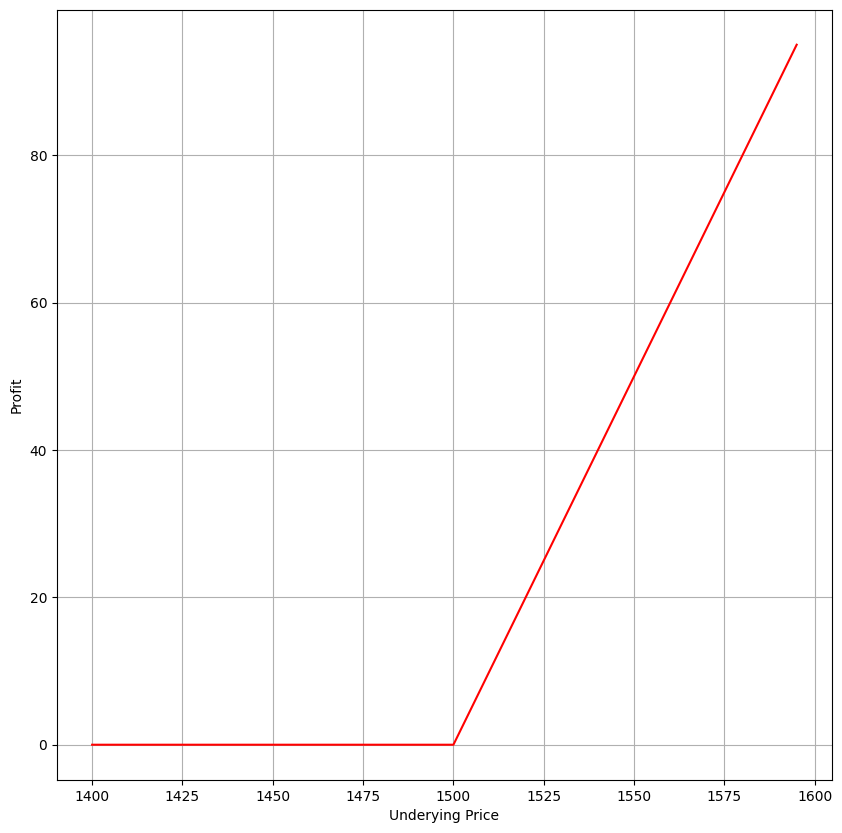

In [8]:
def get_payoffs(side, underlying_prcs, strike_prc):
    if 'CALL' == side:
        payoffs = underlying_prcs - strike_prc
    else:
        payoffs = strike_prc - underlying_prcs
    
    payoffs[payoffs < 0] = 0

    return payoffs


underlying_prcs = np.arange(1400, 1600, 5)
strike_prc = 1500
payoffs = get_payoffs('CALL', underlying_prcs, strike_prc)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.grid(True)
ax.set_xlabel('Underying Price')
ax.set_ylabel('Profit')

ax.plot(underlying_prcs, payoffs, 'r')

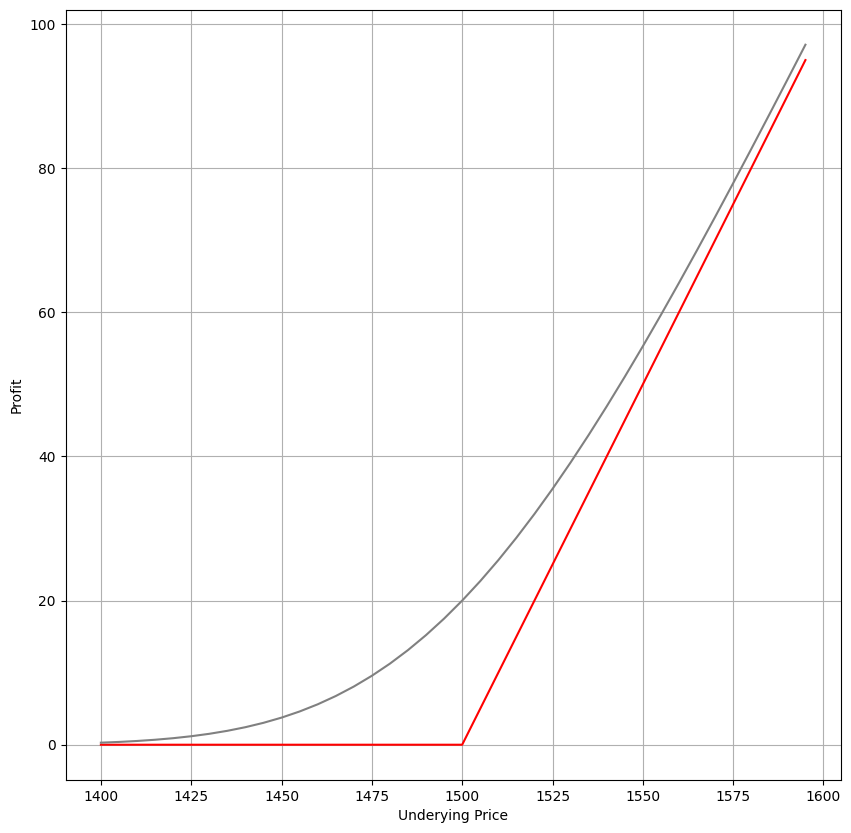

In [9]:
def get_opt_prcs(side, underlying_prcs, cur_underlying_prc, strike_prc, opt_prc, remain_year, interest_rate):
    iv = get_iv(side, opt_prc, cur_underlying_prc, strike_prc, remain_year, interest_rate)
    opt_prcs = get_opt_prc(side, underlying_prcs, strike_prc, remain_year, interest_rate, iv)
    return opt_prcs

side = 'CALL'
strike_prc = 1500
cur_underlying_prc = 1500
opt_prc = 20
remain_year = 0.022
interest_rate = 0.05
underlying_prcs = np.arange(1400, 1600, 5)

payoffs = get_payoffs(side, underlying_prcs, strike_prc)
opt_prcs = get_opt_prcs(side, underlying_prcs, cur_underlying_prc, strike_prc, opt_prc, remain_year, interest_rate)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.grid(True)
ax.set_xlabel('Underying Price')
ax.set_ylabel('Profit')

ax.plot(underlying_prcs, payoffs, 'r')
ax.plot(underlying_prcs, opt_prcs, 'gray')

In [10]:
def get_opt_masters() -> dict:
    ret = dict()

    resp = requests.get('https://eapi.binance.com/eapi/v1/exchangeInfo').json()
    opt_symbols = resp.get('optionSymbols', [])
    cur_ts = time.time() * 1000

    for opt_symbol in opt_symbols:
        underlying: str = opt_symbol['underlying']

        if 'ETHUSDT' != underlying:
            continue
        
        exp_date: int = opt_symbol['expiryDate']
        
        if exp_date - cur_ts < 86400000:
            continue

        symbol: str = opt_symbol['symbol']
        side: str = opt_symbol['side']
        strike_prc: float = float(opt_symbol['strikePrice'])
    
        ret[symbol] = {
            'underlying': underlying,
            'strike_prc': strike_prc,
            'side': side,
            'exp_date': exp_date
        }

    return ret

masters = get_opt_masters()
print(masters)

{'ETH-221230-800-C': {'underlying': 'ETHUSDT', 'strike_prc': 800.0, 'side': 'CALL', 'exp_date': 1672387200000}, 'ETH-221230-800-P': {'underlying': 'ETHUSDT', 'strike_prc': 800.0, 'side': 'PUT', 'exp_date': 1672387200000}, 'ETH-221230-1000-C': {'underlying': 'ETHUSDT', 'strike_prc': 1000.0, 'side': 'CALL', 'exp_date': 1672387200000}, 'ETH-221230-1000-P': {'underlying': 'ETHUSDT', 'strike_prc': 1000.0, 'side': 'PUT', 'exp_date': 1672387200000}, 'ETH-221230-1300-C': {'underlying': 'ETHUSDT', 'strike_prc': 1300.0, 'side': 'CALL', 'exp_date': 1672387200000}, 'ETH-221230-1300-P': {'underlying': 'ETHUSDT', 'strike_prc': 1300.0, 'side': 'PUT', 'exp_date': 1672387200000}, 'ETH-221230-1600-C': {'underlying': 'ETHUSDT', 'strike_prc': 1600.0, 'side': 'CALL', 'exp_date': 1672387200000}, 'ETH-221230-1600-P': {'underlying': 'ETHUSDT', 'strike_prc': 1600.0, 'side': 'PUT', 'exp_date': 1672387200000}, 'ETH-221230-1900-C': {'underlying': 'ETHUSDT', 'strike_prc': 1900.0, 'side': 'CALL', 'exp_date': 167238

In [11]:
def get_spot_prc_ticker(symbol: str) -> float:
    resp = requests.get(f'https://api.binance.com/api/v3/ticker/price?symbol={symbol}').json()
    return float(resp['price'])

def get_fut_prc_ticker(symbol: str) -> float:
    resp = requests.get(f'https://fapi.binance.com/fapi/v1/ticker/price?symbol={symbol}').json()
    return float(resp['price'])

def get_opt_mid_prc(symbol: str) -> float:
    resp = requests.get(f'https://eapi.binance.com/eapi/v1/depth?symbol={symbol}&limit=10').json()
    best_ask_prc = float(resp['asks'][0][0]) if 0 < len(resp['asks']) else 0
    best_bid_prc = float(resp['bids'][0][0]) if 0 < len(resp['bids']) else 0
    return (best_ask_prc + best_bid_prc) * 0.5

print('ETHUSDT 현물 가격:', get_spot_prc_ticker('ETHUSDT'))
print('ETHUSDT 선물 가격:', get_fut_prc_ticker('ETHUSDT'))
print('ETH-221230-800-C 옵션 가격:', get_opt_mid_prc('ETH-221230-800-C'))

ETHUSDT 현물 가격: 1282.8
ETHUSDT 선물 가격: 1282.35
ETH-221230-800-C 옵션 가격: 330.1


In [12]:
def on_chg(strike_prc_rng, underlying_prc, symbol, entry_prc, qty):
    master = masters[symbol]
    strike_prc = master['strike_prc']

    underlying_prcs = np.arange(strike_prc_rng[0], strike_prc_rng[1], 25)

    if 'CALL' == master['side']:
        payoff = underlying_prcs - strike_prc
        payoff[payoff < 0] = 0

    else:
        payoff = strike_prc - underlying_prcs
        payoff[payoff < 0] = 0

    profit = (payoff - entry_prc) * qty

    plt.grid(True)
    plt.xlabel('Underying Price')
    plt.ylabel('Profit')

    if strike_prc_rng[0] <= underlying_prc and underlying_prc <= strike_prc_rng[1]:
        plt.axvline(underlying_prc, color='black', linestyle='--')

    plt.plot(underlying_prcs, profit, 'r')
    plt.show()

opt_symbols = list(masters.keys())
opt_symbols.sort()

widgets.interactive(
    on_chg,
    strike_prc_rng=widgets.IntRangeSlider(description='행사가범위', min=500, max=5000, step=25, continuous_update=False),
    underlying_prc=widgets.FloatText(description='기초자산가격', value=get_spot_prc_ticker('ETHUSDT')),
    symbol=widgets.Dropdown(description='심볼', options=opt_symbols),
    entry_prc=widgets.FloatText(description='진입가'),
    qty=widgets.FloatText(description='수량', value=1)
)

interactive(children=(IntRangeSlider(value=(1625, 3875), continuous_update=False, description='행사가범위', max=500…

In [13]:
my_positions = []

opt_symbols = list(masters.keys())
opt_symbols.sort()

strike_prc_rng_widget = widgets.IntRangeSlider(description='행사가범위', min=500, max=5000, step=25)
strike_prc_rng_widget2 = widgets.IntRangeSlider(description='행사가범위', min=500, max=5000, step=25)
underlying_prc_widget = widgets.FloatText(description='기초자산가격', value=get_spot_prc_ticker('ETHUSDT'))
symbol_widget = widgets.Dropdown(description='심볼', options=opt_symbols)
opt_prc_widget = widgets.FloatText(description='옵션가격', value=get_opt_mid_prc(symbol_widget.value))
interest_rate_widget = widgets.FloatText(description='이자율', value=0.053)
interest_rate_widget2 = widgets.FloatText(description='이자율', value=0.053)
entry_prc_widget = widgets.FloatText(description='진입가')
qty_widget = widgets.FloatText(description='수량', value=1)
add_btn_widget = widgets.Button(description='추가')
calc_btn_widget = widgets.Button(description='합성포지션계산')
clean_btn_widget = widgets.Button(description='초기화')
output = widgets.Output()
output2 = widgets.Output()
output3 = widgets.Output()
output4 = widgets.Output()


@output.capture(clear_output=True)
def on_chg_inputs(strike_prc_rng, underlying_prc, option_prc, interest_rate, entry_prc, qty):
    symbol = symbol_widget.value
    master = masters[symbol]
    side = master['side']
    strike_prc = master['strike_prc']
    exp_date = master['exp_date']
    remain = (exp_date/1000 - time.time()) / 31536000

    underlying_prcs = np.arange(strike_prc_rng[0], strike_prc_rng[1], 25)

    if 'CALL' == master['side']:
        payoff = underlying_prcs - strike_prc
        payoff[payoff < 0] = 0

    else:
        payoff = strike_prc - underlying_prcs
        payoff[payoff < 0] = 0
    
    iv = get_iv(side, option_prc, underlying_prc, strike_prc, remain, interest_rate)
    opt_prcs = get_opt_prc(side, underlying_prcs, strike_prc, remain, interest_rate, iv)

    profits = (payoff - entry_prc) * qty
    opt_prcs = (opt_prcs - entry_prc) * qty

    plt.grid(True)
    plt.xlabel('Underying Price')
    plt.ylabel('Profit')

    if strike_prc_rng[0] <= underlying_prc and underlying_prc <= strike_prc_rng[1]:
        plt.axvline(underlying_prc, color='black', linestyle='--')

    plt.plot(underlying_prcs, profits, 'r')
    plt.plot(underlying_prcs, opt_prcs, 'gray')
    plt.show()
    
    with output2:
        output2.clear_output()
        d1, d2 = get_d1_with_d2(underlying_prc, strike_prc, remain, interest_rate, iv)
        print('IV:', iv)
        print('delta:', get_delta(side, d1))
        print('gamma:', get_gamma(underlying_prc, remain, iv, d1))
        print('theta:', get_theta(side, underlying_prc, strike_prc, remain, interest_rate, iv, d1, d2) / 365)
        print('vega:', get_vega(underlying_prc, remain, d1) * 0.01)
        print('rho:', get_rho(side, strike_prc, remain, interest_rate, d2) * 0.01)

@output4.capture(clear_output=True)
def on_click_calc_tot_positions(clicked_button):
    underlying_prc = get_spot_prc_ticker('ETHUSDT')
    interest_rate = interest_rate_widget2.value
    
    strike_prc_rng = strike_prc_rng_widget2.value
    underlying_prcs = np.arange(strike_prc_rng[0], strike_prc_rng[1], 25)
    tot_profits = np.zeros_like(underlying_prcs)
    tot_opt_prcs = np.zeros_like(underlying_prcs)
    
    for position in my_positions:
        symbol = position['symbol']
        entry_prc = position['entry_prc']
        qty = position['qty']
        master = masters[symbol]
        side = master['side']
        strike_prc = master['strike_prc']
        exp_date = master['exp_date']
        remain = (exp_date/1000 - time.time()) / 31536000
        option_prc = get_opt_mid_prc(symbol)
        
        if 'CALL' == master['side']:
            payoff = underlying_prcs - strike_prc
            payoff[payoff < 0] = 0

        else:
            payoff = strike_prc - underlying_prcs
            payoff[payoff < 0] = 0

        iv = get_iv(side, option_prc, underlying_prc, strike_prc, remain, interest_rate)
        opt_prcs = get_opt_prc(side, underlying_prcs, strike_prc, remain, interest_rate, iv)

        profits = (payoff - entry_prc) * qty
        opt_prcs = (opt_prcs - entry_prc) * qty
        tot_profits = tot_profits + profits
        tot_opt_prcs = tot_opt_prcs + opt_prcs
    
    plt.grid(True)
    plt.xlabel('Underying Price')
    plt.ylabel('Profit')

    if strike_prc_rng[0] <= underlying_prc and underlying_prc <= strike_prc_rng[1]:
        plt.axvline(underlying_prc, color='black', linestyle='--')

    plt.plot(underlying_prcs, tot_profits, 'r')
    plt.plot(underlying_prcs, tot_opt_prcs, 'gray')
    plt.show()

def on_click_add(clicked_button):
    global my_positions
    
    my_pos = {
        'symbol': symbol_widget.value,
        'entry_prc': entry_prc_widget.value,
        'qty': qty_widget.value
    }
    my_positions.append(my_pos)
    
    with output3:
        print('position', my_pos)

def on_click_clean(clicked_button):
    global my_positions
    my_positions = []
    output3.clear_output()
    output4.clear_output()

def on_chg_symbol(symbol):
    opt_prc_widget.value = get_opt_mid_prc(symbol['new'])

add_btn_widget.on_click(on_click_add)
calc_btn_widget.on_click(on_click_calc_tot_positions)
clean_btn_widget.on_click(on_click_clean)
symbol_widget.observe(on_chg_symbol, names='value')

widgets.interactive(
    on_chg_inputs,
    strike_prc_rng=strike_prc_rng_widget,
    underlying_prc=underlying_prc_widget,
    option_prc=opt_prc_widget,
    interest_rate=interest_rate_widget,
    entry_prc=entry_prc_widget,
    qty=qty_widget
)

inputs_layout = widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='center',
    width='350px'
)

inputs = widgets.VBox([
    strike_prc_rng_widget,
    underlying_prc_widget,
    symbol_widget,
    opt_prc_widget,
    interest_rate_widget,
    entry_prc_widget,
    qty_widget,
    add_btn_widget
], layout=inputs_layout)

input_hbox = widgets.HBox([inputs, output, output2])
input_hbox.layout.height = '450px'

contents = widgets.VBox([
    widgets.Label(value='========================================================== 입력 =========================================================='),
    input_hbox,
    widgets.Label(value='========================================================== 합성 =========================================================='),
    strike_prc_rng_widget2,
    interest_rate_widget2,
    calc_btn_widget,
    clean_btn_widget,
    output3,
    output4
])

display(contents)